In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (9, 5)

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import datetime
from dateutil.relativedelta import relativedelta
from arch import arch_model

# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

p = print

Используем полезные функции, любезно предоставленные лектором

In [186]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    rolmean = pd.rolling_mean(y, window=12)
    rolstd = pd.rolling_std(y, window=12)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        rolmean.plot(ax=ts_ax, color='red')
        rolstd.plot(ax=ts_ax, color='black')
        ts_ax.set_title('Original(blue), Rolling Mean(red) & Standard Deviation(black)')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')

        plt.tight_layout()
    return

In [274]:
#######################
# разложение на компоненты
#########################
def seasonal_decompose_plot(y,  freq=None):
    if not isinstance(y, pd.Series): # не является рядом?
        y = pd.Series(y) # преобразовать в ряд

    decomposition = seasonal_decompose(y, freq=freq)
    # fig = plt.figure()
    fig = decomposition.plot()
    fig.set_size_inches(15, 8)
    return

In [188]:
################
 # Dickey-Fuller
##################
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [189]:
# Выбор модели ARIMA согласно AIC
def arima_best_order(timeseries):
    max_lag = 30
    best_aic = np.inf
    best_order = None
    best_mdl = None
    pq_rng = range(5)  # [0,1,2,3,4]
    d_rng = range(2)  # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(timeseries, order=(i, d, j)).fit(maxlag=max_lag, method='mle', trend='nc')
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_mdl

In [190]:
def mape_f(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true.shape))

In [191]:
# Выбор модели ARIMA согласно MAPE
def arima_best_order_mape(timeseries):
    max_lag = 30
    best_mape = np.inf
    best_order = None
    best_mdl = None
    pq_rng = range(5)  # [0,1,2,3,4]
    d_rng = range(3)  # [0,1]
    for i in pq_rng:        
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(timeseries, order=(i, d, j)).fit(maxlag=max_lag, method='mle', trend='nc')
                    mdl_pred = tmp_mdl.predict()
                    delta = timeseries.shape[0]-mdl_pred.shape[0]
                    if delta >0 :
                        tmp_mape = mape_f(timeseries[:-delta], mdl_pred)
                    else:
                        tmp_mape = mape_f(timeseries, mdl_pred)
                    
                    if tmp_mape < best_mape:
                        best_mape = tmp_mape
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    p('mape: {:6.5f} | order: {}'.format(best_mape, best_order))
    return best_mdl

In [192]:
# зафиксируем выборку
np.random.seed(1)

# Исследуем реальные данные

In [193]:
# Загрузим данные
cols = ['num_tr']
df = pd.read_csv('Sales.csv', index_col=0, names=cols , skiprows=1)
df.index.name='date'
df.reset_index(inplace=True)

In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
date      144 non-null object
num_tr    144 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.3+ KB


In [195]:
df.describe()

,num_tr
count,144.000000
mean,389.694444
std,171.500016
min,138.000000
25%,248.500000
50%,369.000000
75%,509.250000
max,871.000000


In [196]:
df.tail()

,date,num_tr
139,Aug-14,848
140,Sep-14,640
141,Oct-14,581
142,Nov-14,519
143,Dec-14,605


In [197]:
#  Укажем формат времени
start = datetime.datetime.strptime("2003-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,144)]
df['index'] = date_list
df.set_index(['index'], inplace=True)
df.index.name=None

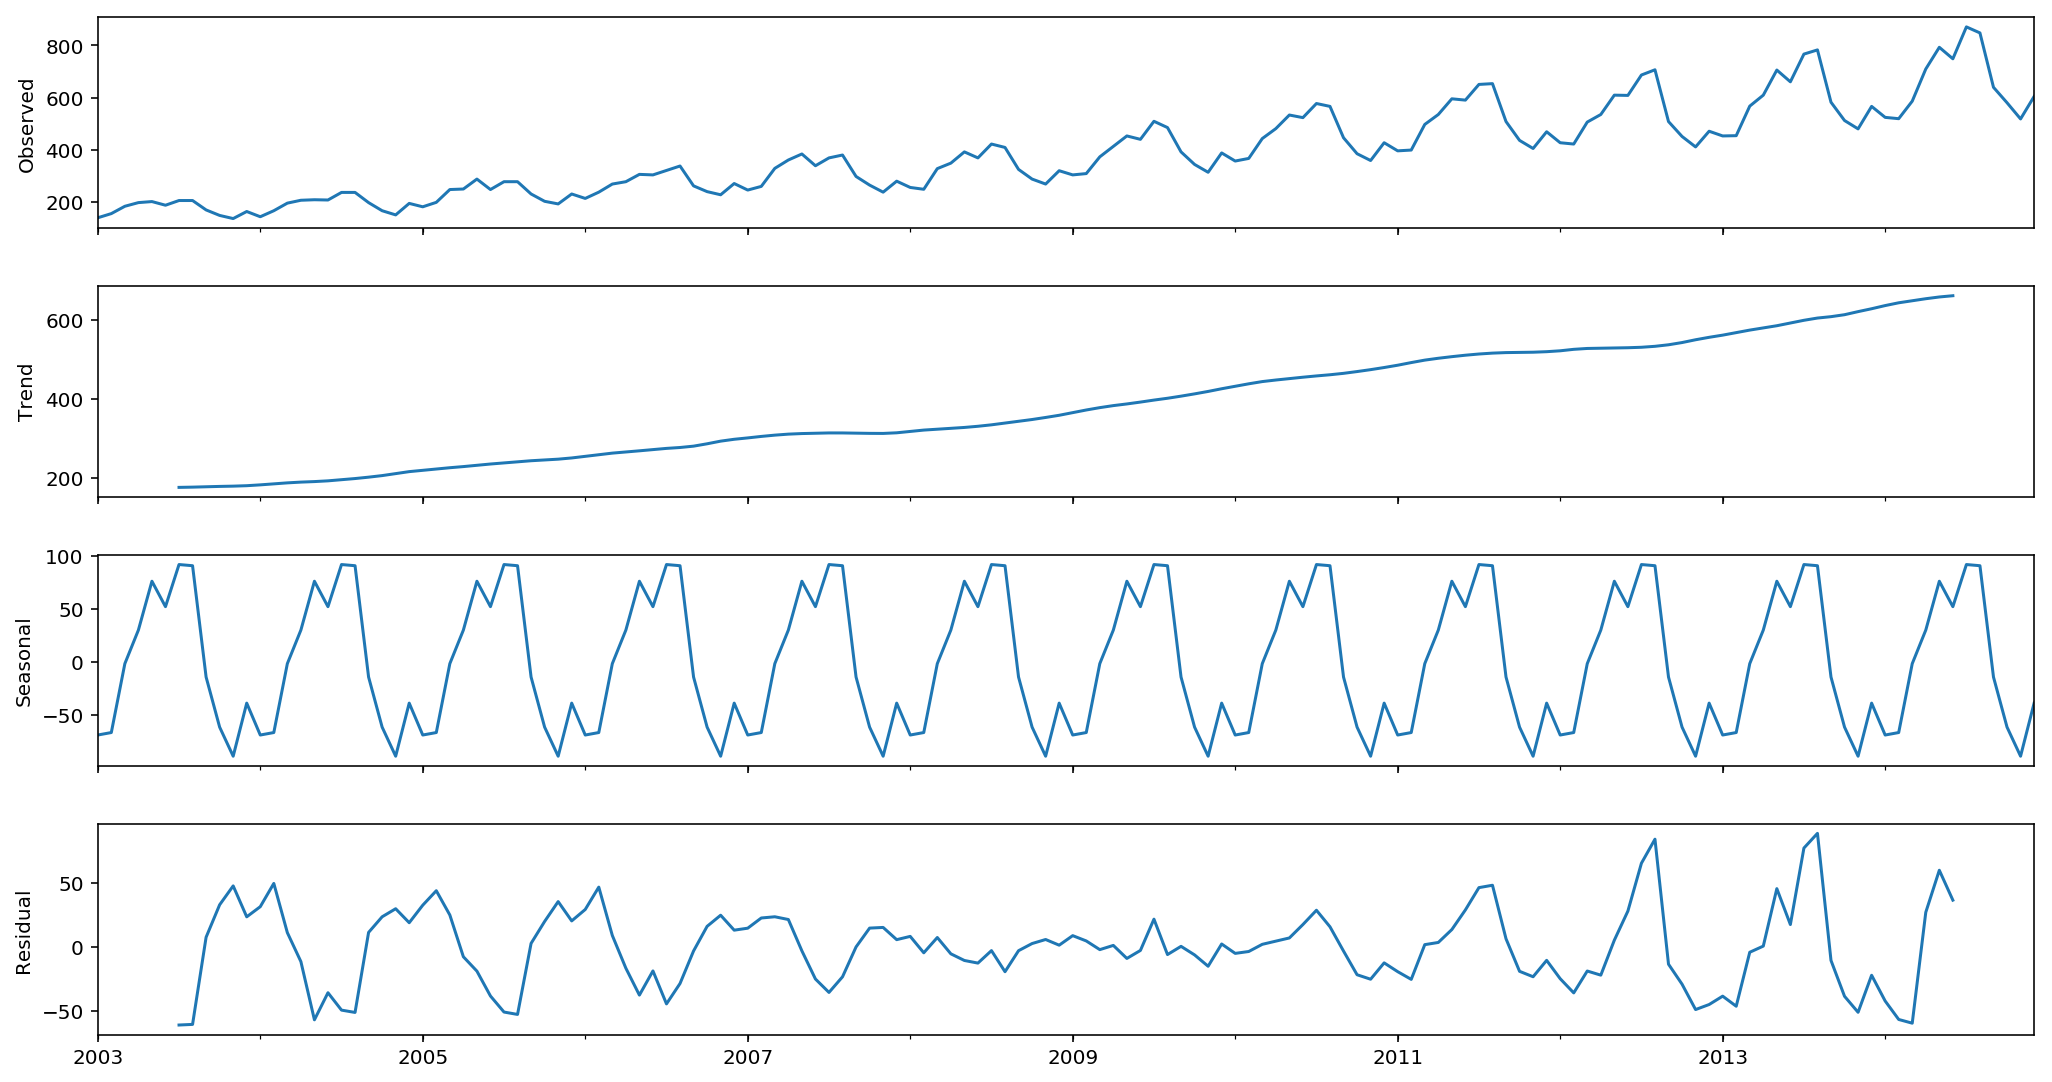

In [275]:
seasonal_decompose_plot(df.num_tr,  freq=12)

п. 2 Постройте график ряда, сделайте предположение о тренде, сезонности, стационарности

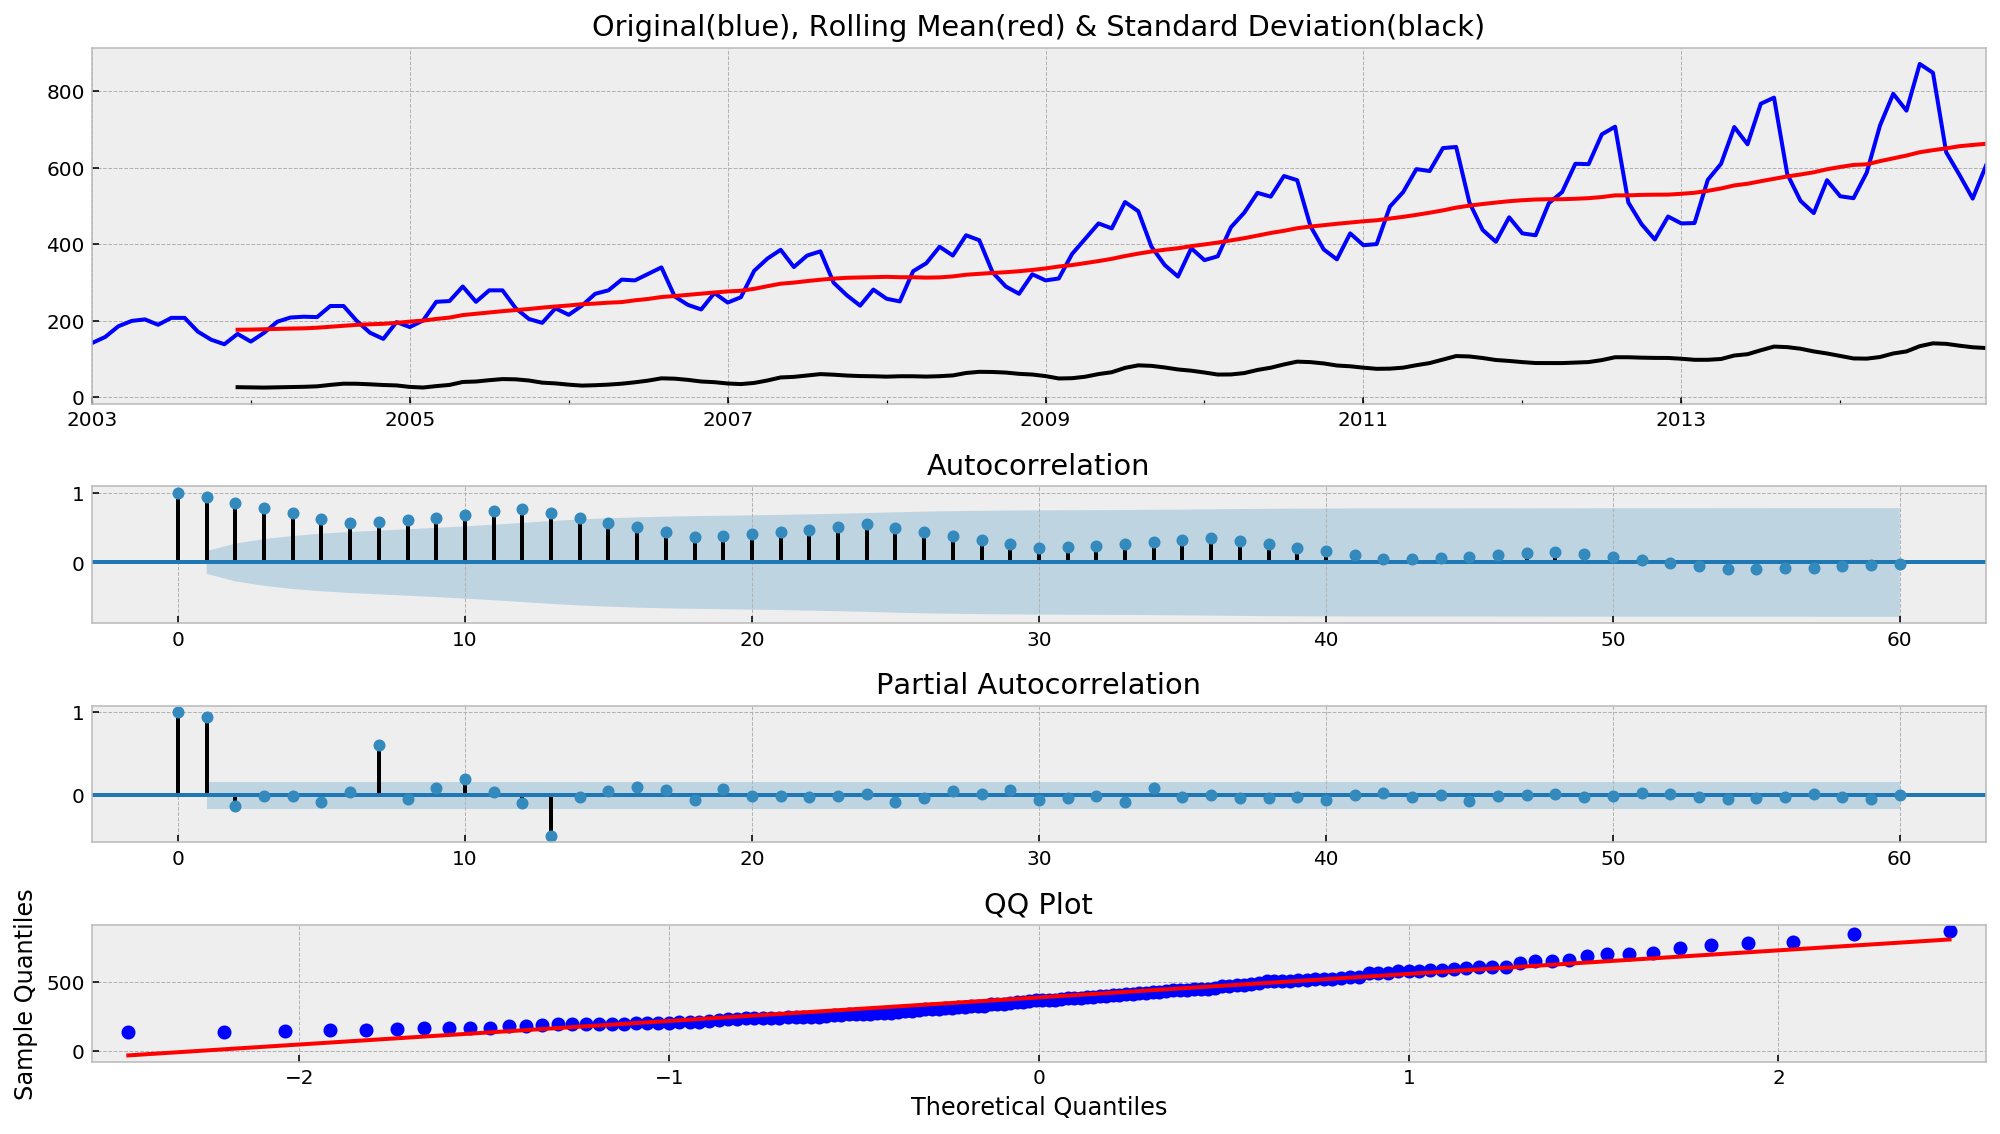

In [198]:
tsplot(df.num_tr, lags=60)

Из анализа изображений: временной ряд с трендом, 
нестационарный - график автокорреляционной функции медленно угасает;
частная автокорреляция показывает, что есть сезонность в 6-ом и 12-ом месяцах;
QQ график показывает, что временной ряд далек от стационарности.

In [199]:
test_stationarity(df.num_tr)

Results of Dickey-Fuller Test:
Test Statistic                   1.108825
p-value                          0.995291
#Lags Used                      14.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


Гипотеза о стационарности после теста Дики-Фуллера отвергается, нестационарный временной ряд.

п. 3 Разделите контрольную (последние 5 мес.) и обучающую (остальное) выборки

In [200]:
train = df[df.index < '2014-08-01']
test = df[df.index >= '2014-08-01']

In [201]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5 entries, 2014-08-01 to 2014-12-01
Data columns (total 2 columns):
date      5 non-null object
num_tr    5 non-null int64
dtypes: int64(1), object(1)
memory usage: 120.0+ bytes


In [202]:
test.head()

,date,num_tr
2014-08-01,Aug-14,848
2014-09-01,Sep-14,640
2014-10-01,Oct-14,581
2014-11-01,Nov-14,519
2014-12-01,Dec-14,605


п. 4 Приведите исходный ряд к стационарному

Results of Dickey-Fuller Test:
Test Statistic                  -1.436190
p-value                          0.564809
#Lags Used                      13.000000
Number of Observations Used    125.000000
Critical Value (1%)             -3.483779
Critical Value (5%)             -2.884954
Critical Value (10%)            -2.579257
dtype: float64


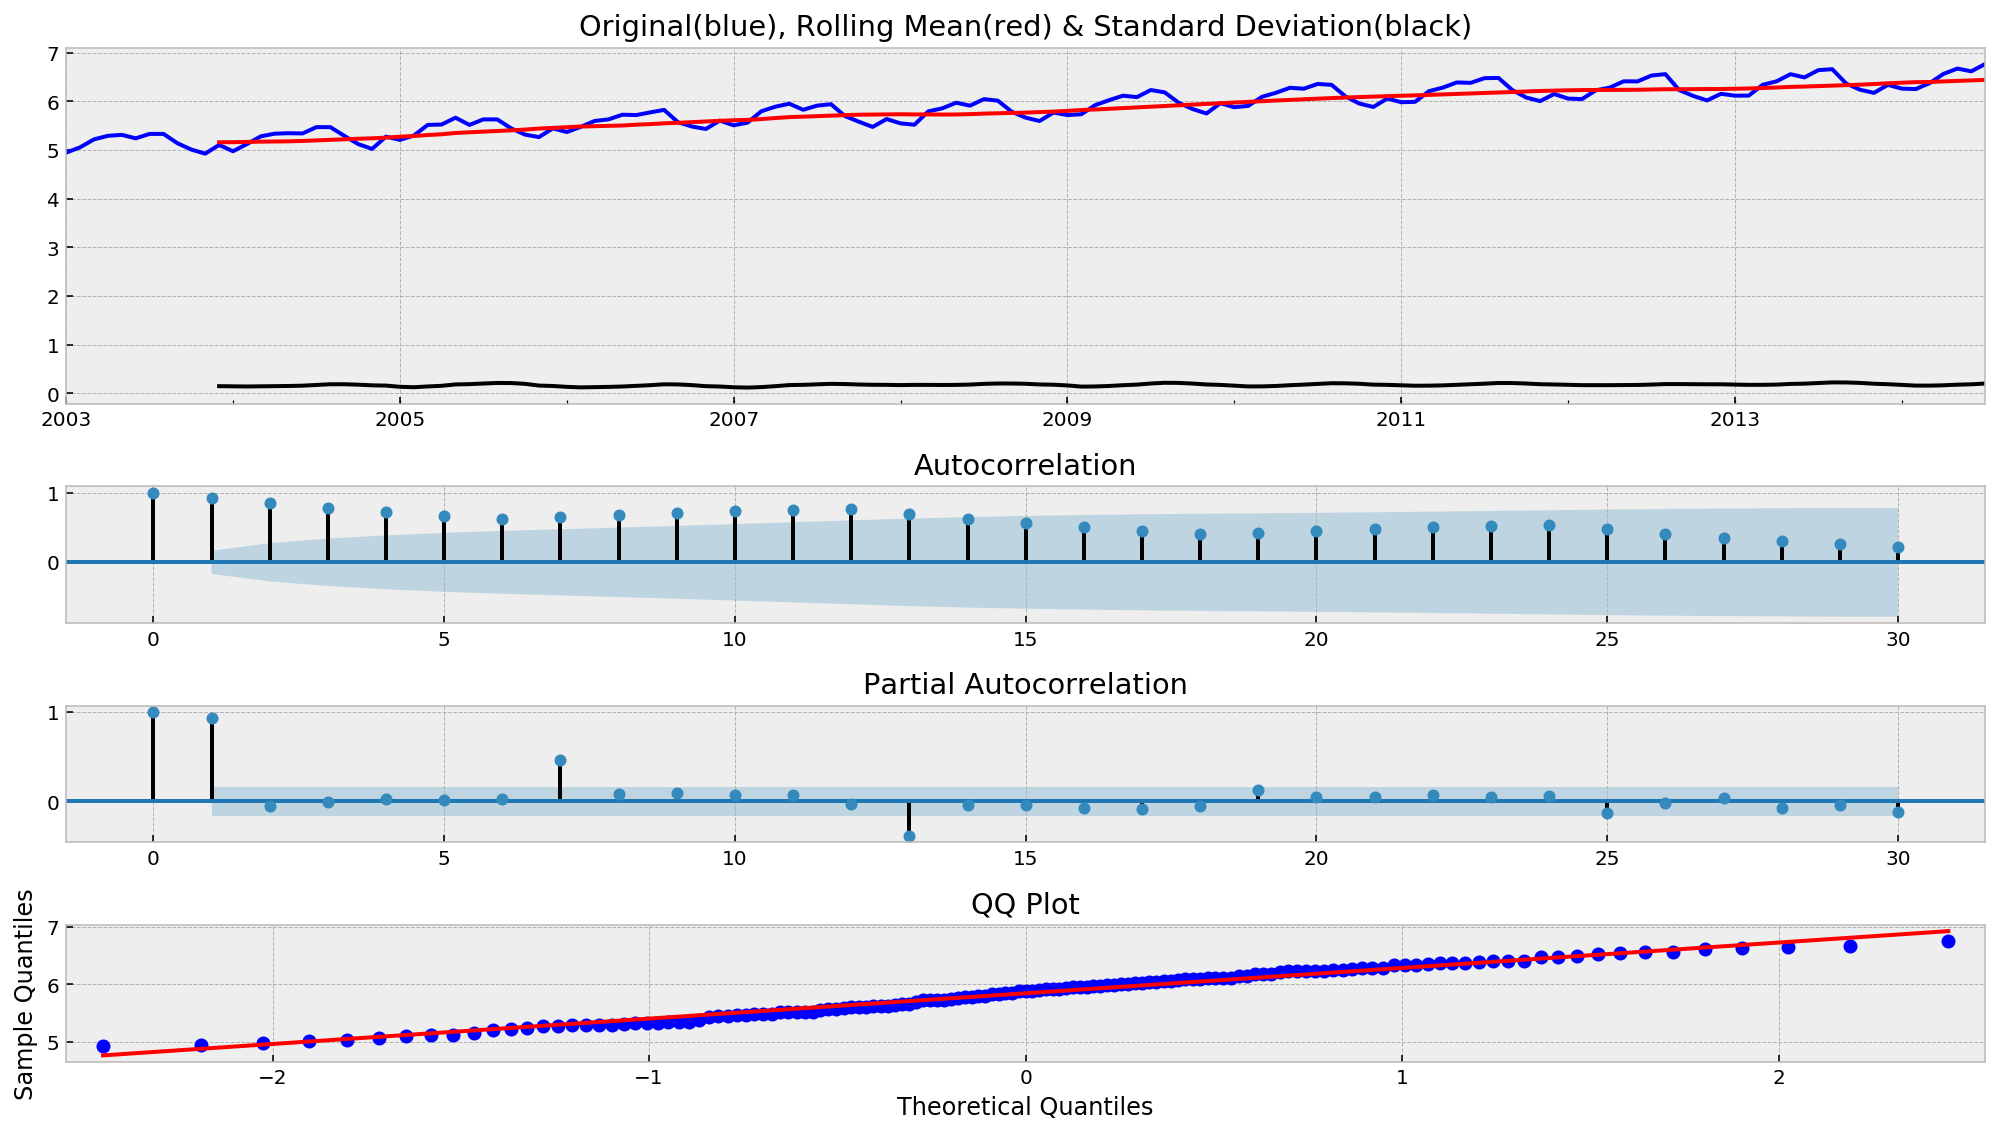

In [203]:
# логарифмируем, на всякий случаем проверяем ДФ, отрисовываем графики, чтобы понять, как изменился временной ряд
train.num_tr_log = train.num_tr.apply(lambda x: np.log(x))
df.num_tr_log = df.num_tr.apply(lambda x: np.log(x))
test_stationarity(train.num_tr_log.dropna(inplace=False))
tsplot(train.num_tr_log, lags=30)

Нестационарный, продолжаем работу с данными



Results of Dickey-Fuller Test:
Test Statistic                  -2.293495
p-value                          0.174074
#Lags Used                      14.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64


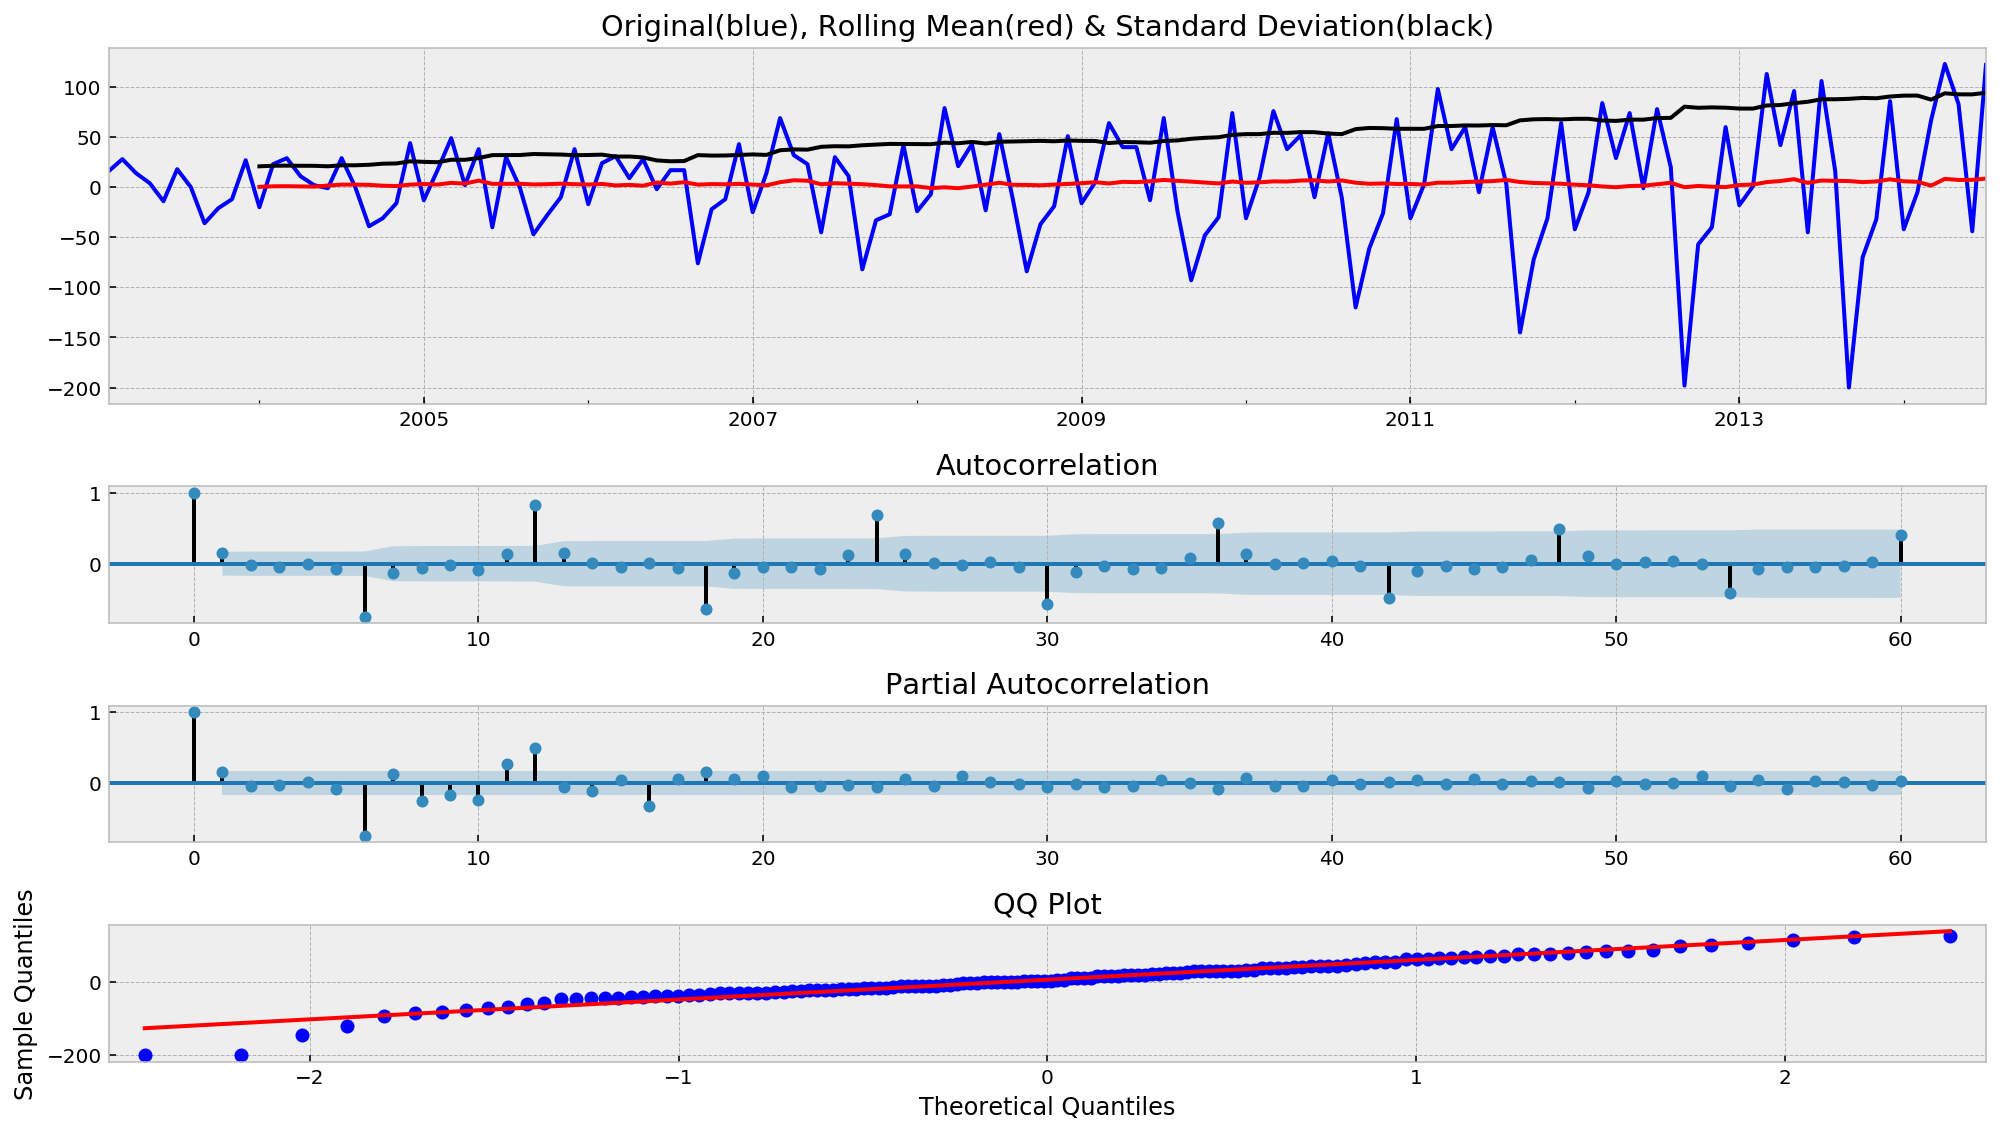

In [204]:
#первые разности 
train['first_difference'] = train.num_tr - train.num_tr.shift(1)
df['first_difference'] = df.num_tr - df.num_tr.shift(1)
test_stationarity(train.first_difference.dropna(inplace=False))
tsplot(train.first_difference[1:], lags = 60)

Нестационарный, продолжаем работать с данными

Results of Dickey-Fuller Test:
Test Statistic                  -2.689739
p-value                          0.075831
#Lags Used                      14.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64


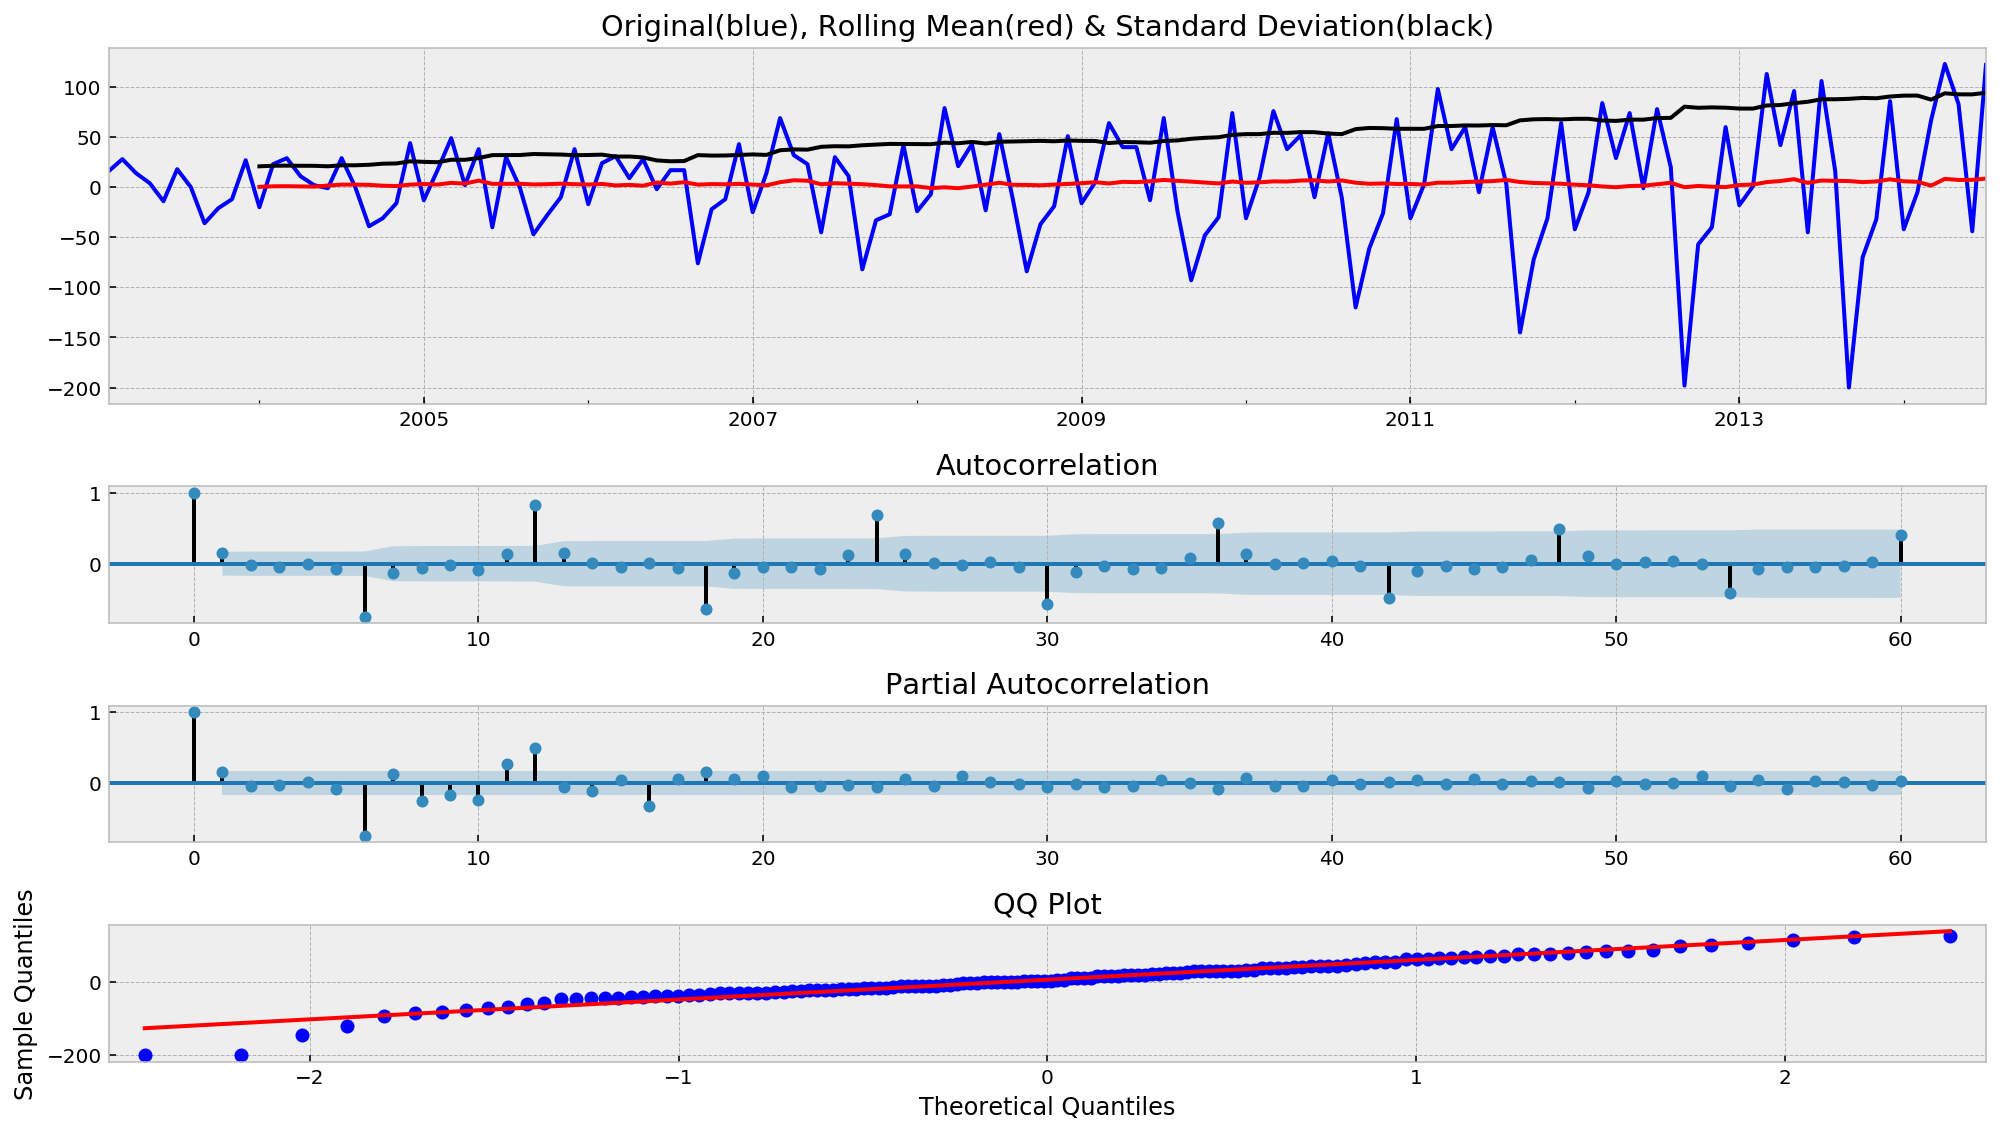

In [205]:
# логарифм первых разностей 
train['log_first_difference'] = train.num_tr_log - train.num_tr_log.shift(1)
test_stationarity(train.log_first_difference.dropna(inplace=False))
tsplot(train.first_difference[1:], lags = 60)

Нестационарный, продолжаем преобразовывать временной ряд

Results of Dickey-Fuller Test:
Test Statistic                  -2.927774
p-value                          0.042212
#Lags Used                       1.000000
Number of Observations Used    125.000000
Critical Value (1%)             -3.483779
Critical Value (5%)             -2.884954
Critical Value (10%)            -2.579257
dtype: float64


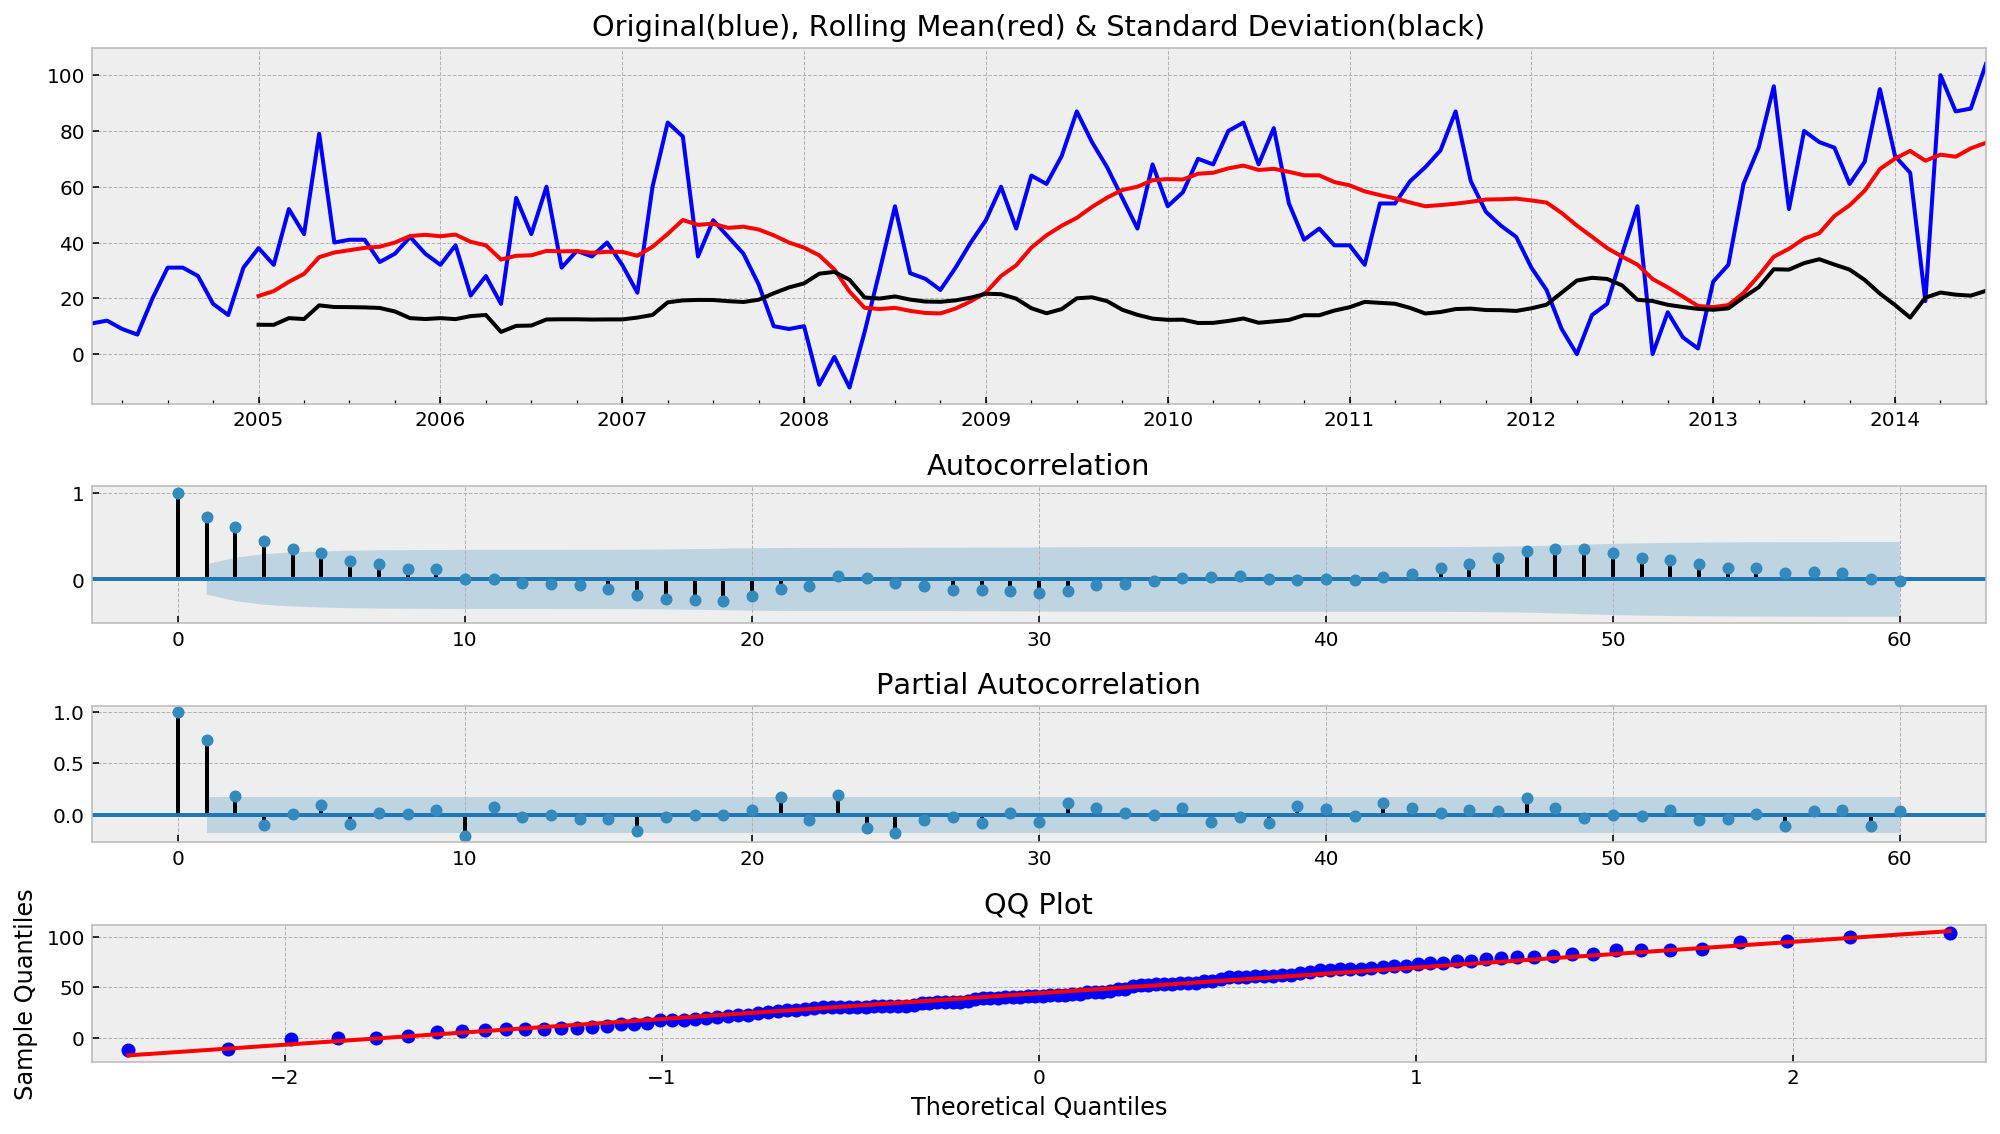

In [206]:
# seasonal component 12 month, ярко выражена на графике частой автокорреляции, 
# есть компоента на 6-ти месяцах, ее пока не принимаем во внимание
train['seasonal_difference'] = train.num_tr -  train.num_tr.shift(12)
test_stationarity(train.seasonal_difference.dropna(inplace=False))
tsplot(train.seasonal_difference[13:], lags = 60)

По тесту ДФ ряд можно считать стационарным (p-value < 0.05), по посмотрим, можно ли как-то улучшить результат, улучшить поведение
автокорреляционной фукции и частной автокорреляции.

Results of Dickey-Fuller Test:
Test Statistic                  -2.680078
p-value                          0.077549
#Lags Used                      12.000000
Number of Observations Used    114.000000
Critical Value (1%)             -3.489058
Critical Value (5%)             -2.887246
Critical Value (10%)            -2.580481
dtype: float64


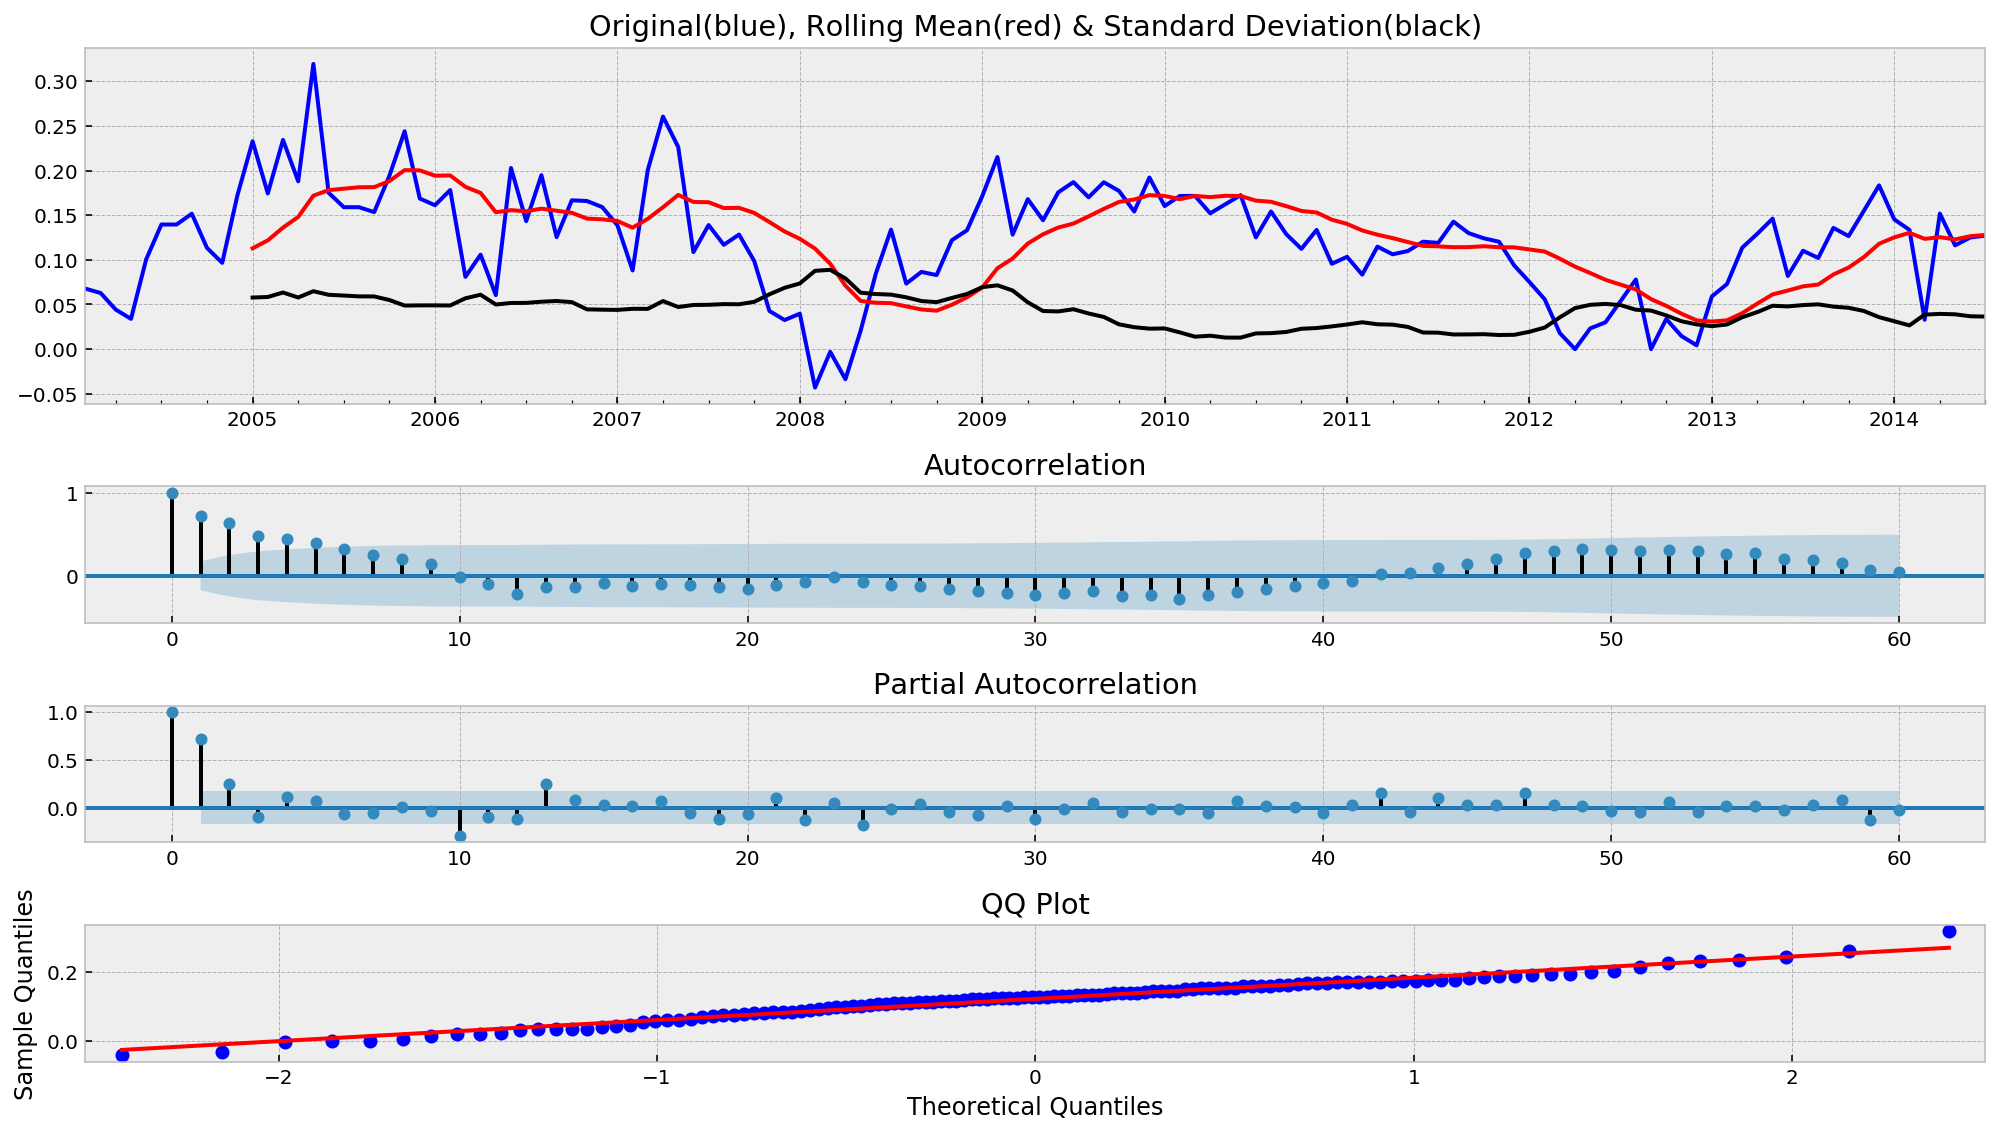

In [207]:
# log seasonal component 12 month 
train['log_seasonal_difference'] = train.num_tr_log - train.num_tr_log.shift(12)
test_stationarity(train.log_seasonal_difference.dropna(inplace=False))
tsplot(train.log_seasonal_difference[13:], lags = 60)

Удаление сезонной компоненты из логарифмированного ряда не дает лучший результат, 
чем простое удаление сезонной компоненты. Продолжаем эксперименты далее.

Results of Dickey-Fuller Test:
Test Statistic                -1.515064e+01
p-value                        6.805180e-28
#Lags Used                     0.000000e+00
Number of Observations Used    1.250000e+02
Critical Value (1%)           -3.483779e+00
Critical Value (5%)           -2.884954e+00
Critical Value (10%)          -2.579257e+00
dtype: float64


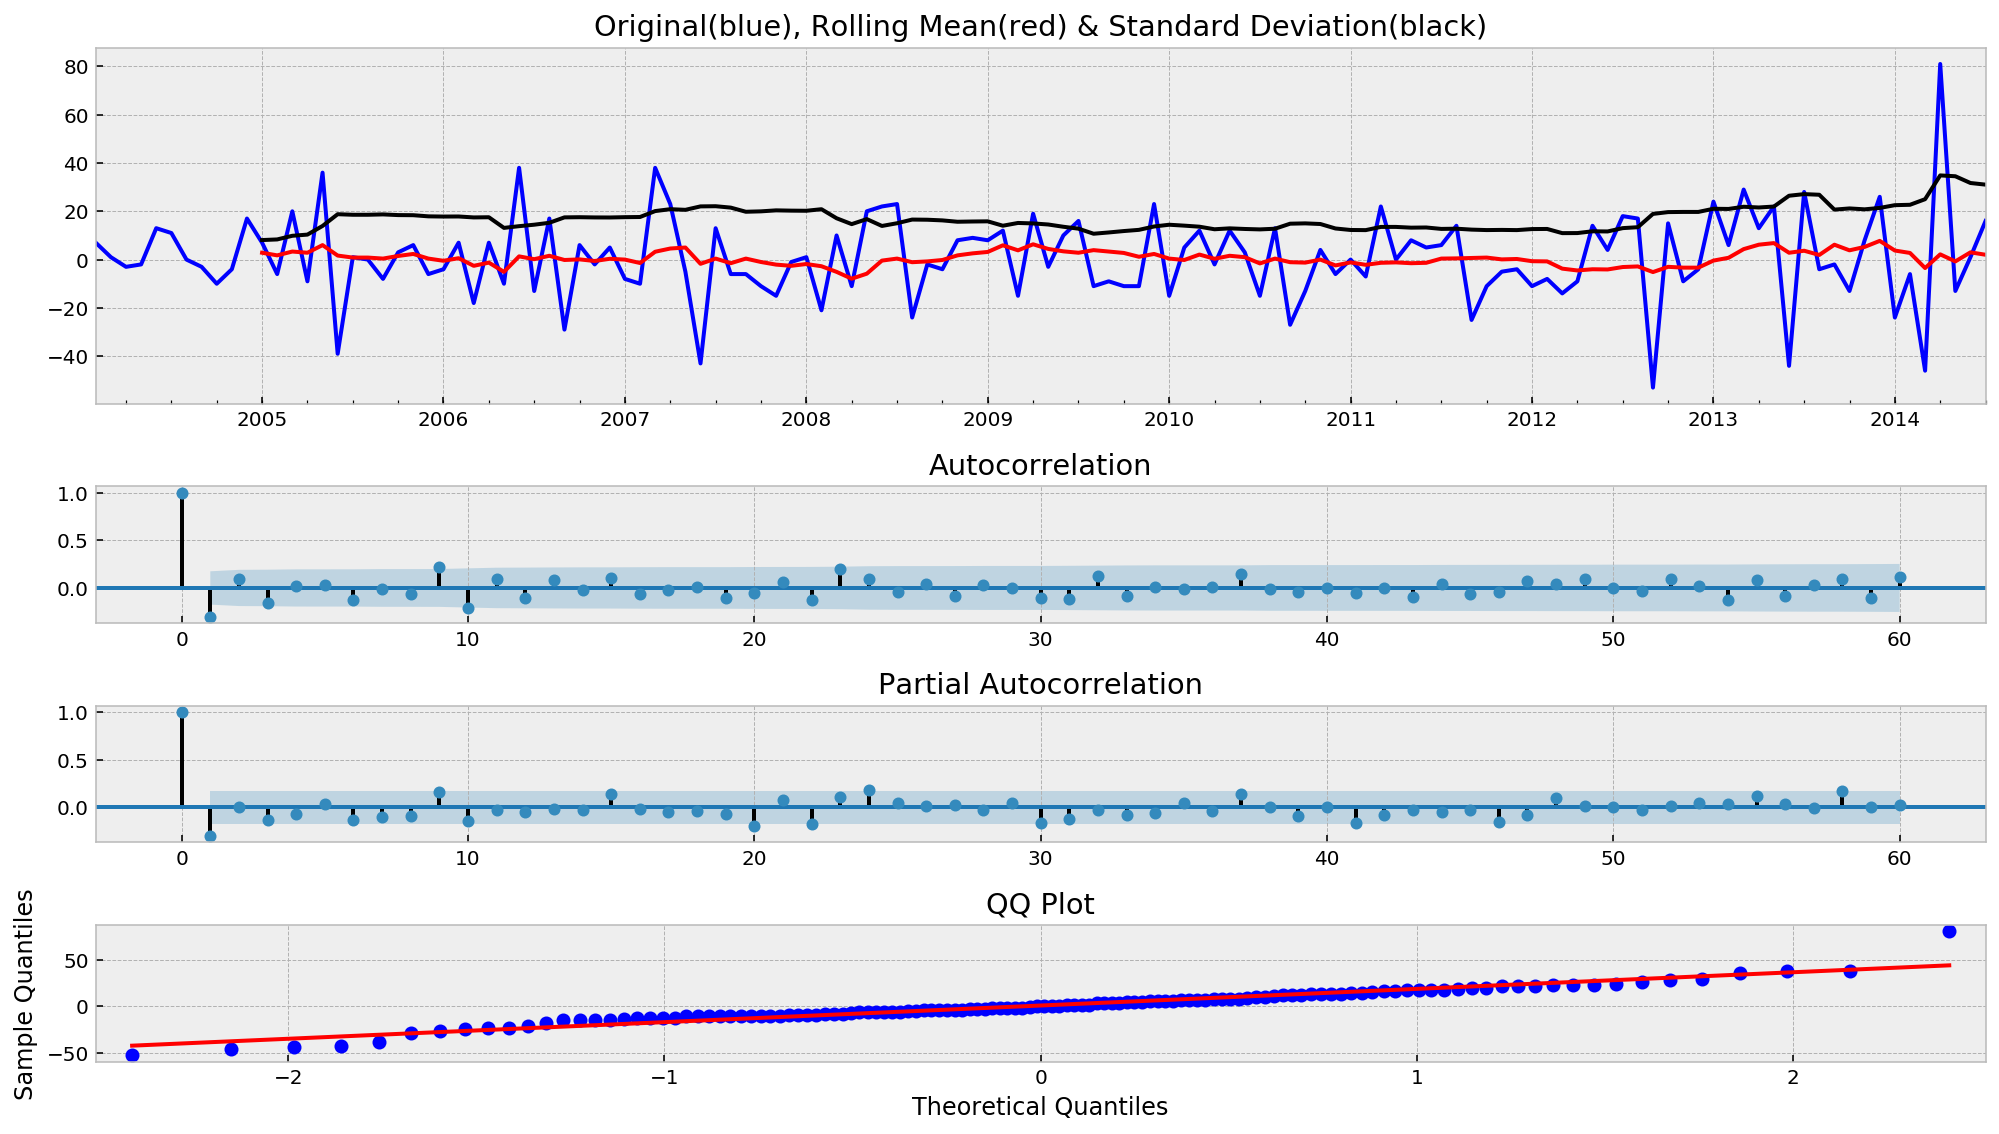

In [208]:
# Удаление сезонной компоненты из ряда с первыми разностями
train['seasonal_first_difference'] = train.first_difference - train.first_difference.shift(12)
df['seasonal_first_difference'] = df.first_difference - df.first_difference.shift(12)
test_stationarity(train.seasonal_first_difference.dropna(inplace=False))
tsplot(train.seasonal_first_difference[13:], lags = 60)

Удаление сезонной компоненты из ряда первых разностей дает очень хороший результат. Тест ДФ с очень низким p-value. 
Корелляционные функции после первого лага затухли и колеблются в пределах дисперсии.
QQ plot линейный с единственным выбросом.

Results of Dickey-Fuller Test:
Test Statistic                  -4.386730
p-value                          0.000313
#Lags Used                      12.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


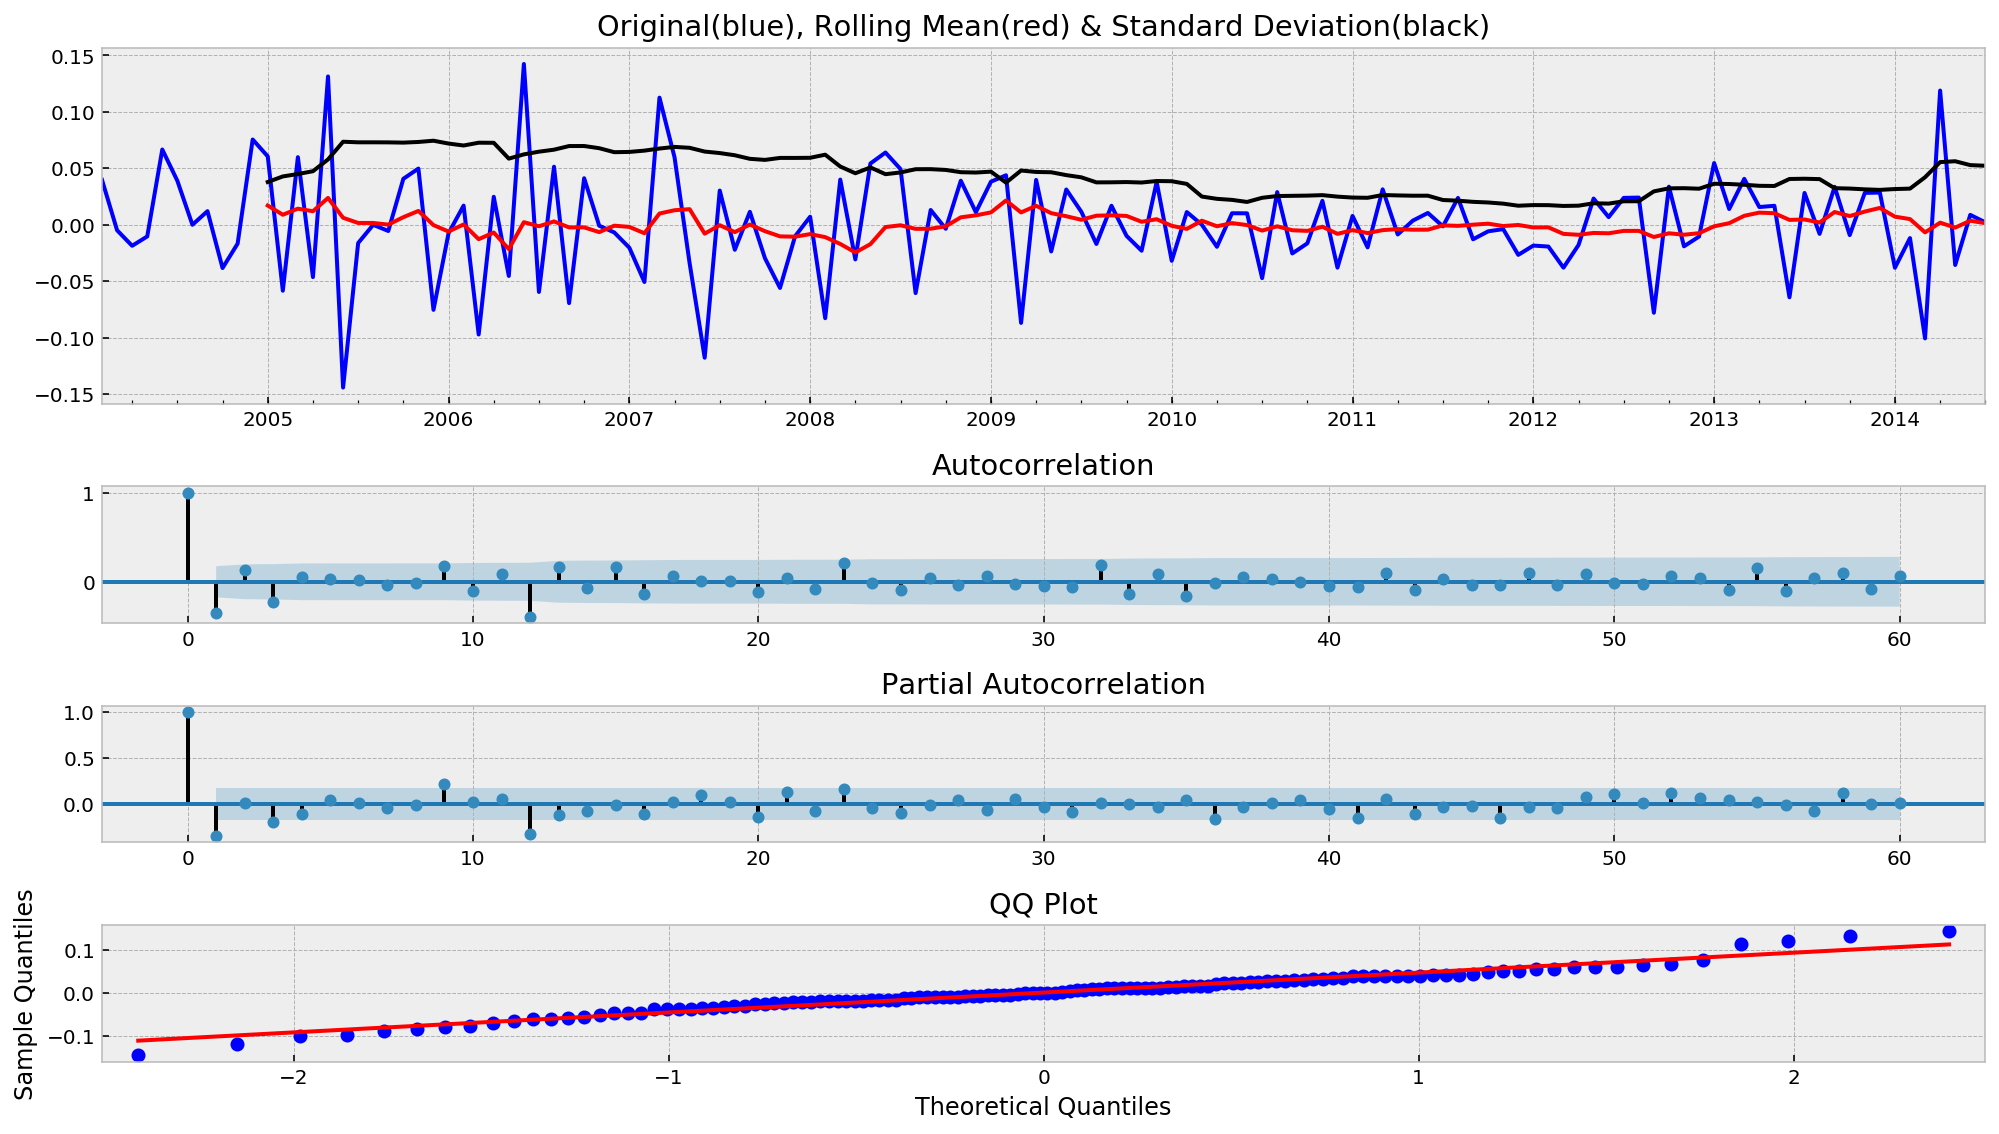

In [209]:
# Удаление сезонной компоненты из логарифмированного ряда первых разностей
train['log_seasonal_first_difference'] = train.log_first_difference - train.log_first_difference.shift(12)
test_stationarity(train.log_seasonal_first_difference.dropna(inplace=False))
tsplot(train.log_seasonal_first_difference[13:], lags = 60)

Удаление сезонной компоненты из логарифмированного ряда первых разностей привело к стационарному ряду, но 
дало не самый лучший результат по оценкам.

В результате экспериментов оказалось, что наилучший способ привести данный ряд к стационарному - удаление сезонной компоненты (12 месяцев) из ряда первых разностей

п. 5 Подберите модель, хорошо описывающую обучающую выборку, каждым способом:

* перебором коэффициентов и сортировкой по AIC;
* перебором коэффициентов и сортировкой по MAP E (mean absolute percentage error);
* с помощью подхода Бокса–Дженкинса к идентификации временных рядов (описан на слайде 22);


а) по AIC

In [210]:
from sklearn.metrics import *

In [211]:
best_mdl = arima_best_order(train.seasonal_first_difference[13:])

aic: 1071.80432 | order: (4, 1, 2)


In [235]:
best_mdl.params

ar.L1.D.seasonal_first_difference   -1.208366
ar.L2.D.seasonal_first_difference   -0.296174
ar.L3.D.seasonal_first_difference   -0.183275
ar.L4.D.seasonal_first_difference   -0.227025
ma.L1.D.seasonal_first_difference   -0.000083
ma.L2.D.seasonal_first_difference   -0.999914
dtype: float64

In [212]:
forcst_aic = best_mdl.forecast(steps=5, alpha = 0.05)
forcst_aic[0]

array([-13.34931972,  15.98061395, -16.69565588,  16.07609359,
       -12.55871911])

In [213]:
start = datetime.datetime.strptime("2014-08-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,5)]

In [215]:
fcst_aic = pd.Series(forcst_aic[0], index=date_list)
fcst_aic

2014-08-01   -13.349320
2014-09-01    15.980614
2014-10-01   -16.695656
2014-11-01    16.076094
2014-12-01   -12.558719
dtype: float64

In [251]:
mse_aic = mean_squared_error(test.num_tr,forcst_aic[0])
print('mse {:.2f}'.format(mse_aic))

mse 424574.83


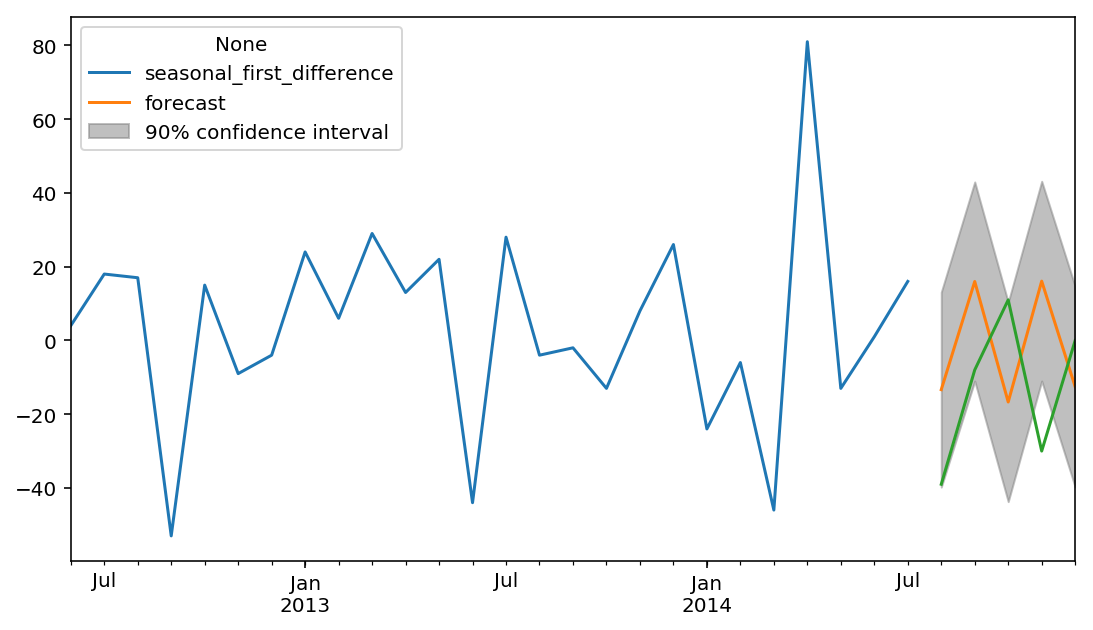

In [223]:
ax = train.seasonal_first_difference[train.index>='2012-06-01'].plot()
best_mdl.plot_predict('2014-08-01', '2014-12-01', dynamic=False, ax=ax, plot_insample=False, alpha=0.1)
df.seasonal_first_difference[df.index>='2014-08-01'].plot()

test - зеленая линия

forecast - оранжевая линия

б) по MAP E

In [255]:
mape = train.seasonal_first_difference[13:]

In [256]:
best_mdl_m = arima_best_order_mape(mape)

mape: 0.09564 | order: (4, 0, 2)


In [257]:
best_mdl_m.params

ar.L1.seasonal_first_difference   -0.296625
ar.L2.seasonal_first_difference    0.874461
ar.L3.seasonal_first_difference    0.217343
ar.L4.seasonal_first_difference   -0.163379
ma.L1.seasonal_first_difference   -0.000020
ma.L2.seasonal_first_difference   -0.999976
dtype: float64

In [258]:
forcst_mape = best_mdl_m.forecast(steps=5, alpha = 0.05)
forcst_mape[0]

array([-23.80988277,   7.92798514, -19.85834522,   5.0342114 ,
       -13.24550426])

In [270]:
mse_mape = mean_squared_error(test.num_tr,forcst_mape[0])
print('mse {:.2f}'.format(mse_mape))

mse 433397.32


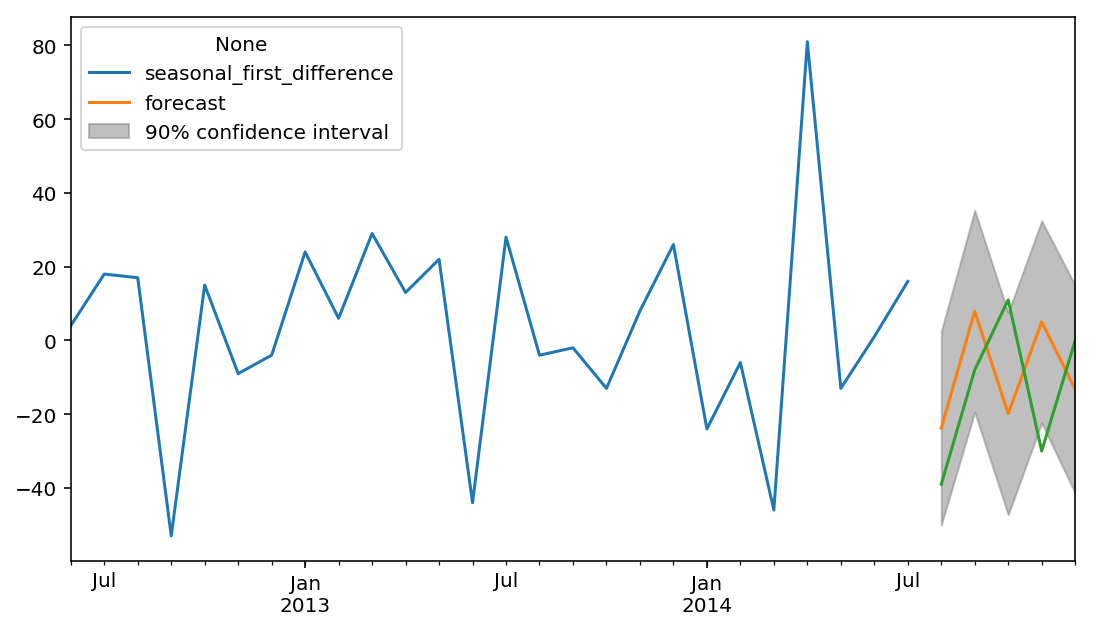

In [260]:
#строим прогноз
ax = train.seasonal_first_difference[train.index>='2012-06-01'].plot()
best_mdl_m.plot_predict('2014-08-01', '2014-12-01', dynamic=False, ax=ax, plot_insample=False, alpha=0.1)
df.seasonal_first_difference[df.index>='2014-08-01'].plot() #test data

test - зеленая линия

forecast - оранжевая линия

In [261]:
Параметры моделей по AIC и MAPE практически не отличаются

AIC
ar.L1.D.seasonal_first_difference   -1.208366
ar.L2.D.seasonal_first_difference   -0.296174
ar.L3.D.seasonal_first_difference   -0.183275
ar.L4.D.seasonal_first_difference   -0.227025
ma.L1.D.seasonal_first_difference   -0.000083
ma.L2.D.seasonal_first_difference   -0.999914


SyntaxError: invalid syntax (<ipython-input-261-7539a8b0ca75>, line 1)

In [262]:
MAPE
ar.L1.seasonal_first_difference   -0.296625
ar.L2.seasonal_first_difference    0.874461
ar.L3.seasonal_first_difference    0.217343
ar.L4.seasonal_first_difference   -0.163379
ma.L1.seasonal_first_difference   -0.000020
ma.L2.seasonal_first_difference   -0.999976

SyntaxError: invalid syntax (<ipython-input-262-2839f0f179c2>, line 3)

в) по Боксу-Дженкинсу

по графикам корреляции визуально определяем, что есть компоненты p = 1, q = 1 (первые лаги больше доверительного интервала).
Используем модель arima(1,1,1)

In [263]:
best_mdl_bj = smt.ARIMA(train.seasonal_first_difference[13:], order=(1, 1, 1)).fit(maxlag=30, method='mle', trend='nc')

In [264]:
print(best_mdl_bj.summary())

                                  ARIMA Model Results                                  
Dep. Variable:     D.seasonal_first_difference   No. Observations:                  125
Model:                          ARIMA(1, 1, 1)   Log Likelihood                -535.389
Method:                                    mle   S.D. of innovations             17.157
Date:                         Mon, 19 Feb 2018   AIC                           1076.778
Time:                                 00:45:42   BIC                           1085.263
Sample:                             03-01-2004   HQIC                          1080.225
                                  - 07-01-2014                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
ar.L1.D.seasonal_first_difference    -0.2969      0.085     -3.481      0.001      -0.464   

Гипотеза для заданных параметров не отвергается, AIC очень близок к модели, выбранной автоматически по AIC.
Строим прогноз

In [265]:
forcst_bj = best_mdl_bj.forecast(steps=5, alpha = 0.05)
forcst_bj[0]

array([-3.8941945 ,  2.01282251,  0.25890129,  0.77967847,  0.62504845])

In [271]:
mse_bj = mean_squared_error(test.num_tr,forcst_bj[0])
print('mse {:.2f}'.format(mse_bj))

mse 420766.59


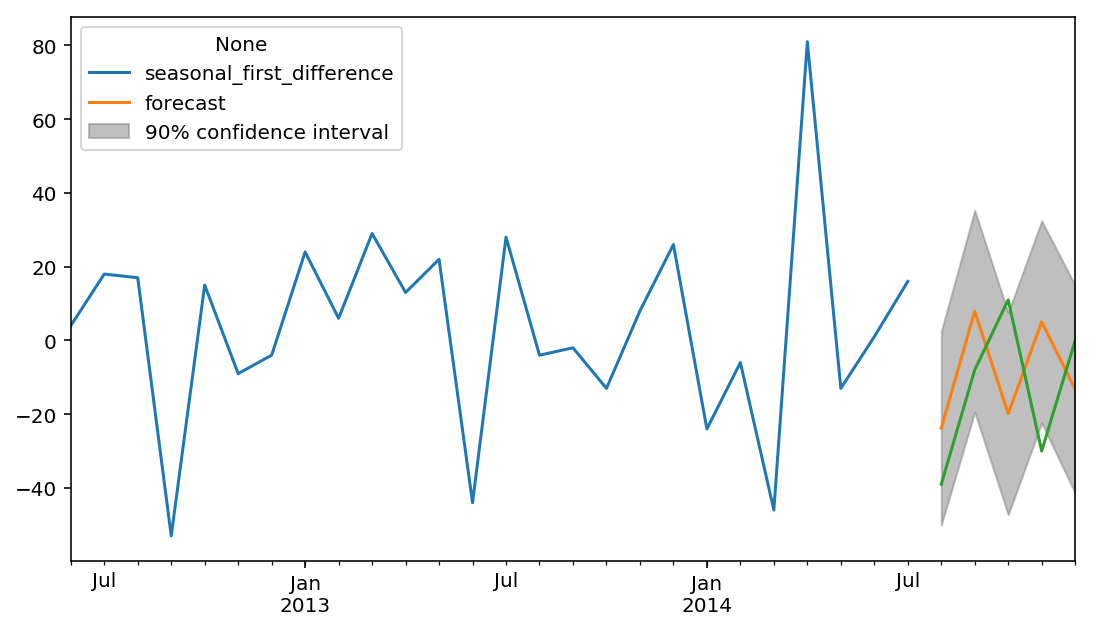

In [267]:
#строим прогноз 
ax = train.seasonal_first_difference[train.index>='2012-06-01'].plot()
best_mdl_m.plot_predict('2014-08-01', '2014-12-01', dynamic=False, ax=ax, plot_insample=False, alpha=0.1)
df.seasonal_first_difference[df.index>='2014-08-01'].plot() #test data

Все подходы дают близкий прогноз, но я бы остановилась на модели ARIMA(1,1,1) по Боксу-Дженкинску, тк она проще 
по количеству задаваемых параметров

При оценке модели наименьшую ошибка по данным, полученным методом Бокса-Денкинса